+ 8855 imágenes de train 
+ 2933 imágenes de test
+ 10 captions por imagen

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import numpy.random as random
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from collections import defaultdict # diccionario que al asignar un nuevo valor crea la clave
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
    

from nltk.tokenize import RegexpTokenizer # A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow import keras

from transformers import CLIPTokenizer, TFCLIPTextModel


# PARAMS 

In [2]:
data_dir = "../data/birds"
EMBEDDINGS_NUM = 10 # OLD número de captions por imagen
WORDS_NUM = 18 # número maximo de palabras por caption. Si es menos se hace padding, si es mas se trunca
BRANCH_NUM = 0  # número de veces que cargo cada imagen. Si es 0 cargamos solo la imagen del tamaño dado
BASE_SIZE = 64 # Tamaño mínimo de las imagenes. Cada imagen que cargaremos tendrá el doble de tamaño que la anterior. la última el tamaño original 
NOISE_SIZE = 128 # power of 2
CONDITION_DIM = 100
OUT_EMB = 512

Guía de funcioens de carga
https://github.com/mrlibw/ControlGAN/blob/master/code/datasets.py

# LOAD AND PREPARE

In [3]:
class PREPARE_CAPTIONS():
    """
    CLASE PARA PREPARAR EL PICKLE DE CAPTIONS. 
    PASAMOS A INDÍCES LOS CAPTIONS (SEGÚN VOCABULARIO CREADO)
    """
    def __init__(self, data_dir, split='train'):
        self.EMBEDDINGS_NUM = EMBEDDINGS_NUM
        self.data_dir = data_dir
        
    def load_filenames(self, data_dir, filenames):
        """
        Cargamos los pickles de los filenames. Contienen los names de la imagen/caption.
        """

        filepath = '%s/%s/filenames.pickle' % (data_dir, split)
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as f:
                filenames = pickle.load(f)
            print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        else:
            filenames = []
        return filenames

    def load_captions(self, data_dir, filenames):
        all_captions = []
        for i in range(len(filenames)):
            cap_path = '%s/text/%s.txt' % (data_dir, filenames[i])
            with open(cap_path, "r") as f:
                # Leemos cada línea y lo metemos en una lista 
                captions = f.read().split('\n')
                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # Nos quedamos solo con secuencias alfanuméricas como tokens, borramos el resto
#                    tokenizer = RegexpTokenizer(r'\w+')
#                    tokens = tokenizer.tokenize(cap.lower())
#                    if len(tokens) == 0:
#                        print('cap', cap)
#                        continue
#                    tokens_new = []
#                    for t in tokens:
#                        t = t.encode('ascii', 'ignore').decode('ascii')
#                        if len(t) > 0:
#                            tokens_new.append(t)
#                    all_captions.append(tokens_new)
                    all_captions.append(cap)
#                    cnt += 1
#                    if cnt == self.EMBEDDINGS_NUM:
#                        break
#                if cnt < self.EMBEDDINGS_NUM:
#                    print('ERROR: the captions for %s less than %d' % (filenames[i], cnt))
        return all_captions

    def build_dictionary(self, train_captions, test_captions):
        """
        Creo diccionarios. 
        Vocabulario.
        Captions como indices.
        Indíces a words
        Words a índices
        Número de palabras.
        """

        # Creo diccionario de palabras existentes: número de aparaciones 
        word_counts = defaultdict(float)
        captions = train_captions + test_captions
        for sent in captions:
            for word in sent:
                word_counts[word] += 1

        # Creo vocabulario
        vocab = [w for w in word_counts if word_counts[w] >= 0]
        # Añado al vocabulario "end"
        # Creo los intercambios de indices-palabras y viceversa
        ixtoword = {}
        ixtoword[0] = '<end>'
        wordtoix = {}
        wordtoix['<end>'] = 0
        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1

        # Train: pasar los captions a indices
        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            train_captions_new.append(rev)

        # Test: pasar los captions a indices
        test_captions_new = []
        for t in test_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            test_captions_new.append(rev)

        return [train_captions_new, test_captions_new, ixtoword, wordtoix, len(ixtoword)]

    def load_text_data(self, data_dir, split):
        """
        Funcion para leer los pickles segun splits
        Return: 
            + filenames: 
            + captions: 
            + ixtoword: 
            + wordtoix: 
            + n_words:  número de palabras
        """
        # Cargamos los pickles de los splits:
        filepath = os.path.join(data_dir, 'captions.pickle')
        train_names = self.load_filenames(data_dir, 'train')
        test_names = self.load_filenames(data_dir, 'test')

        # Si no existe creamos el captions.pickle con los captions como indices y los diccionarios 
        # para pasar al vocabulario
        if not os.path.isfile(filepath):
            # Cargamos los descriptores
            train_captions = self.load_captions(data_dir, train_names)
            test_captions = self.load_captions(data_dir, test_names)
            # Diccionario de vocabulario (y de índice a palabras y viceversa)
            # y paso los captions a índices:
            #train_captions, test_captions, ixtoword, wordtoix, n_words = self.build_dictionary(train_captions, test_captions)
            #Guardo todo esto en pickles
            with open(filepath, 'wb') as f:
                pickle.dump([train_captions, test_captions], f, protocol=2)#  ,ixtoword, wordtoix], f, protocol=2)
                print('Save to: ', filepath)
        # Si existe ccaptions.picke lo cargamos 
        else:
            with open(filepath, 'rb') as f:
                print("filepath", filepath)
                x = pickle.load(f)
                train_captions, test_captions = x[0], x[1]
                #ixtoword, wordtoix = x[2], x[3]
                del x
                #n_words = len(ixtoword)
                print('Load from: ', filepath)
        if split == 'train':
            # a list of list: each list contains
            # the indices of words in a sentence
            captions = train_captions
            filenames = train_names
        else:  # split=='test'
            captions = test_captions
            filenames = test_names
        return filenames, captions#, ixtoword, wordtoix, n_words


In [4]:
class PREPARE_IMAGE():
    
    def __init__(self, data_dir, split, captions, filenames, BASE_SIZE):
        self.data_dir = data_dir
        self.imsize = []
        self.BASE_SIZE = BASE_SIZE
        self.captions = captions
        self.filenames = filenames 
        # tamaños a los que escalo
        if BRANCH_NUM>0:
            for i in range(BRANCH_NUM):
                self.imsize.append(self.BASE_SIZE)
                self.BASE_SIZE = self.BASE_SIZE * 2
        else:
            self.imsize.append(self.BASE_SIZE)
        self.bbox = self.load_bbox()        
        self.class_id = self.load_class_id(data_dir, split, len(self.filenames))
    def get_imgs(self, img_path, imsize, bbox=None):
        """
        Función de carga de imagen.
        Realizo crop de la bbox si existe
        """
        
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        # Realizo crop de la bbox si existe
        if bbox is not None:
            r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - r)
            y2 = np.minimum(height, center_y + r)
            x1 = np.maximum(0, center_x - r)
            x2 = np.minimum(width, center_x + r)
            img = img.crop([x1, y1, x2, y2])
        #aumentado con flip
        if np.random.rand()<0.5:
            img = np.fliplr(img)
        # Escalo la imagen a distintos tamaños 
        # La última de las veces NO
        if BRANCH_NUM>0:
            ret = []
            for i in range(BRANCH_NUM):
                if i < (BRANCH_NUM - 1):
                    # re_img = transforms.Scale(imsize[i])(img)
                    re_img = tf.image.resize(img, size=(imsize[i], imsize[i]))
                else:
                    re_img = img
                ret.append((tf.cast(re_img, tf.float32) - 127.5) / 127.5)
        else:
            ret = tf.image.resize(img, size=(imsize[0], imsize[0]))
            ret = (tf.cast(ret, tf.float32) - 127.5) / 127.5 #/255
        return ret  
    
    def load_class_id(self, data_dir, split, total_num):
        """
        Cargamos la información de a que clase pertenece (por id)
        """
        split_dir = os.path.join(data_dir, split)
        if os.path.isfile(split_dir + '/class_info.pickle'):
            with open(split_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f, encoding='latin1')
        else:
            class_id = np.arange(total_num)
        return tf.convert_to_tensor(class_id)
    
    
    def load_bbox(self):
        """
        Leemos las BBox
        """
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)

        filepath = os.path.join(data_dir, 'images.txt')
        df_filenames = pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist() #paths de todas las imágenes
        print('Total filenames: ', len(filenames), filenames[0])
        
        # Paths BBOX
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        
        # Guardo en un diccionario el path y la bbox
        for i in range(0, numImgs):
            bbox = df_bounding_boxes.iloc[i][1:].tolist() #la bbox i
            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        return filename_bbox
    
    
    def get_caption(self, sent_ix):
        """
        sent_ix: numero random del 0 al embeddings num (número de frases por imagen)
        Devuelve un vector de índices del número de palabras fijados (rellenado con 0 si es necesario) 
        """
        
        # Selecciono una frase al azar
        sent_caption = np.asarray(self.captions[sent_ix]).astype('int64')
        if (sent_caption == 0).sum() > 0:
            print('ERROR: do not need END (0) token', sent_caption)
            
        # Creo una vector del tamaño fijado de las frases. Relleno con 0 si hace falta
        # si hay más palabras del número fijado selecciono al azar de la frase ese número de palabras
        num_words = len(sent_caption)
        x = np.zeros((WORDS_NUM, 1), dtype='int64')
        x_len = num_words
        if num_words <= WORDS_NUM:
            x[:num_words, 0] = sent_caption
        else:
            ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
            np.random.shuffle(ix)
            ix = ix[:WORDS_NUM]
            ix = np.sort(ix)
            x[:, 0] = sent_caption[ix]
            x_len = WORDS_NUM
        x = np.squeeze(x)

        return tf.convert_to_tensor(x), tf.convert_to_tensor(x_len)

    def __getitem__(self, index):
        """
        Dado un indice obtenemos:
        + Imagen BRANCH_NUM veces. A distintos tamaños y recortada
        + Un caption bueno (junto a su clase (tipo de pájaro))
        + Un caption malo (junto a su clase (tipo de pájaro))
        + Longitud del caption (fijada por WORDS_NUM)
        """
        key = self.filenames[index]
        cls_id = self.class_id[index]

        if self.bbox is not None:
            bbox = self.bbox[key]
        #    data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
        #    data_dir = self.data_dir
        # Cargo la imagen BRANCH_NUM veces. A distintos tamaños y recortada
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = self.get_imgs(img_name, self.imsize, bbox)
        # Selecciono un caption al azar y lo cargo
        sent_ix = random.randint(0, EMBEDDINGS_NUM)
        new_sent_ix = index * EMBEDDINGS_NUM + sent_ix
        #caps, cap_len = self.get_caption(new_sent_ix)
        caps = self.captions[new_sent_ix]
        
        # Selecciono al azar un caption ERRONEO
        wrong_idx = random.randint(0, len(self.filenames))
        wrong_new_sent_ix = wrong_idx * EMBEDDINGS_NUM + sent_ix
        #wrong_caps, wrong_cap_len = self.get_caption(wrong_new_sent_ix)
        wrong_caps = self.captions[wrong_new_sent_ix]
        wrong_cls_id = self.class_id[wrong_idx]

        #return imgs, caps, cap_len, cls_id, key, wrong_caps, wrong_cap_len, wrong_cls_id
        return imgs, caps, cls_id, key, wrong_caps, wrong_cls_id

In [5]:
split = "train"
prepare_caption = PREPARE_CAPTIONS(data_dir, split)
#filenames, captions, ixtoword, wordtoix, n_words = prepare_caption.load_text_data(data_dir, split)
filenames, captions = prepare_caption.load_text_data(data_dir, split)


Load filenames from: ../data/birds/train/filenames.pickle (8855)
Load filenames from: ../data/birds/train/filenames.pickle (8855)
filepath ../data/birds\captions.pickle
Load from:  ../data/birds\captions.pickle


In [6]:
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)
#imgs, caps, cap_len, cls_id, key, wrong_caps, wrong_cap_len, wrong_cls_id = prepare_image.__getitem__(5)
imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(5)

Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


# MODELOS

In [7]:
# Revisar posibilidad de no meter capas densas y simplemente hacer la lineal de la primera mitad de los elementos y sumar la sigmoid de la segunda mitad de los mismos
class GatedLinearUnit(layers.Layer):
    def __init__(self, units=200):
        super(GatedLinearUnit, self).__init__()
        #self.linear = layers.Dense(units)
        #self.sigmoid = layers.Dense(units, activation="sigmoid")
    def call(self, inputs):
        nc = inputs.shape[1]
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)      
        #return self.linear(inputs) * self.sigmoid(inputs)
        return tf.math.multiply(inputs[:,:nc], tf.keras.activations.sigmoid(inputs[:, nc:]))

class GatedLinearUnit2D(layers.Layer):
    def __init__(self, units=200):
        super(GatedLinearUnit2D, self).__init__()
        #self.linear = layers.Dense(units)
        #self.sigmoid = layers.Dense(units, activation="sigmoid")
    def call(self, inputs):
        nc = inputs.shape[-1]
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)      
        #return self.linear(inputs) * self.sigmoid(inputs)
        return tf.math.multiply(inputs[:,:,:,:nc], tf.keras.activations.sigmoid(inputs[:,:,:,nc:]))    

def cond_aug():
    inputs_emb = tf.keras.layers.Input(shape=(OUT_EMB,))
    x = layers.Dense(CONDITION_DIM*4, use_bias=True)(inputs_emb)
    x = GatedLinearUnit()(x)
    mu = x[:, :CONDITION_DIM]
    logvar = x[:, CONDITION_DIM:]
    std = tf.math.exp(tf.math.multiply(logvar,0.5))
    c_code = tf.random.normal([std.shape[1]], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
    c_code = tf.math.add(tf.math.multiply(std, c_code), mu)
    return tf.keras.Model(inputs_emb, [c_code, mu, logvar], name="cond_aug")

projection_dims = 128
def upsample(filters, size, apply_dropout=False,last = False):
    initializer = tf.random_normal_initializer(0., 0.05)
    result = tf.keras.Sequential()
    if last:
        result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False, activation='sigmoid'))
    else:
        result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    tam_ini = 256
    ca_net = cond_aug()
    
    initializer = tf.random_normal_initializer(0., 0.05)
    inputs_noise = tf.keras.layers.Input(shape=(NOISE_SIZE,))#output 100
    inputs_emb = tf.keras.layers.Input(shape=(OUT_EMB,))
    emb, mu, logvar = ca_net(inputs_emb)

    #if projection_dims!=0:
    #    emb = layers.Dense(projection_dims, use_bias=False)(inputs_emb) #output 128
   # else:
    #    emb = inputs_emb
    x = tf.concat([inputs_noise, emb], 1)#output 228
    # x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dense(4*4*tam_ini, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Reshape((4,4, tam_ini))(x)
    x = upsample(tam_ini, 3, apply_dropout=False)(x)
    x = upsample(tam_ini//2, 3, apply_dropout=False)(x)
    x = upsample(tam_ini//4, 3, apply_dropout=False)(x)
    x = upsample(tam_ini//8, 3)(x)  
    #x = upsample(tam_ini//16, 4)(x) 
    x = upsample(3, 3,last = True)(x)
    return tf.keras.Model([inputs_noise, inputs_emb], [x, mu, logvar], name="generator")

def Discriminador():
    tam_ini = 32
    image_input = tf.keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3))
    inputs_emb = tf.keras.layers.Input(shape=(OUT_EMB,))
    if projection_dims!=0:
        emb = layers.Dense(projection_dims, use_bias=False)(inputs_emb) 
    else:
        emb = inputs_emb 
        
    x = layers.Conv2D(tam_ini, (4, 4), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU()(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(tam_ini*2, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(tam_ini*4, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(tam_ini*8, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)
    
    # print("X shape:",x.shape)
    # x = layers.Conv2D(tam_ini*16, (4, 4), strides=(2, 2), padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    

    #x = layers.Dropout(0.3)(x)
    #x = layers.Conv2D(tam_ini*32, (4, 4), strides=(2, 2), padding='same')(x)
    #x = layers.LeakyReLU()(x)
    #x = layers.Dropout(0.3)(x)
    # print("labels_input shape:", labels_input.shape)
    emb = layers.RepeatVector(16)(emb)
    # print("After, reshape:",emb)
    emb = layers.Reshape((4,4, emb.shape[-1]))(emb)

    x = tf.concat([x, emb], 3)
    # print("After concat reshape:",x.shape)
    x = layers.Conv2D(1, (1, 1), strides=(1,1), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    #print("sh:",x.shape)

    x = layers.Flatten()(x)
    #x = layers.Dense(100)(x)

    output_score = layers.Dense(1,activation="sigmoid")(x)

    return tf.keras.Model([image_input, inputs_emb], output_score, name="discriminator")

In [8]:
def conv3x3(out_planes):
    "3x3 convolution with padding"
    return layers.Conv2D(out_planes, (3, 3), strides=(1, 1), padding='same')

# Upsale the spatial size by a factor of 2
def upBlock(out_planes):
    block =  tf.keras.Sequential([
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        conv3x3(out_planes*2),
        tf.keras.layers.BatchNormalization(),
        GatedLinearUnit2D()
    ])
    return block

# Keep the spatial size
def Block3x3_relu(in_planes, out_planes):
    block =  tf.keras.Sequential([
        conv3x3(out_planes*2),
        tf.keras.layers.BatchNormalization(),
        GatedLinearUnit2D()

    ])
    return block

class ResBlock(layers.Layer):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block =tf.keras.Sequential([
            conv3x3(channel_num * 2),
            tf.keras.layers.BatchNormalization(),
            conv3x3(channel_num),
            tf.keras.layers.BatchNormalization()])

    def call(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out
def Generator():
    tam_ini = 256
    ca_net = cond_aug()

    initializer = tf.random_normal_initializer(0., 0.05)
    inputs_noise = tf.keras.layers.Input(shape=(NOISE_SIZE,))#output 100
    inputs_emb = tf.keras.layers.Input(shape=(OUT_EMB,))
    emb, mu, logvar = ca_net(inputs_emb)
    x = tf.concat([inputs_noise, emb], 1)#output 200
    x = layers.Dense(4*4*tam_ini*2, use_bias=False)(x) #l x por GLU que me divide el tamaño
    x = GatedLinearUnit()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Reshape((4,4, tam_ini))(x)

    x = upBlock(tam_ini//2)(x)
    x = upBlock(tam_ini//4)(x)
    x = upBlock(tam_ini//8)(x)  
    x = upBlock(tam_ini//16)(x)
    #x = upBlock(tam_ini//32)(x)

    x = conv3x3(3)(x)
    x = tf.keras.activations.tanh(x)
    return tf.keras.Model([inputs_noise, inputs_emb], [x, mu, logvar], name="generator")


In [9]:
generator = Generator()
generator.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 cond_aug (Functional)          [(None, 100),        205200      ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                          

In [10]:
discriminator = Discriminador()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 32)   1568        ['input_4[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 64)   32832       ['leaky_re_lu[0][0]']            
                                                                                      

### Text encoder

Aun no claro si conviene o no usar este embedding y entrenarlo junto con el discriminador y generador. Seria una parte de ambas redes.

# Train

Labels discriminador:
+ 0 Imagen falsa para el discriminador
+ 0 Imagen verdadera pero mal texto 
+ 1 Verdadera imagen y texto asociado

Labels generador:
+ 1 Falsa imagen y generada con texto real

In [11]:
#def kl_divergence(mu, logvar):
#    # Computes KL(p || q). Note that outside of this function, P is the target distribution
#    # and Q is the approximating distribution. Inside of this function, P is just the
#    # first argument and Q is the second.
#    # I inefficiently iterate through all of the q and p values to
#    # only compute the log when p_i > 0.
#    KLD_element = tf.math.add(tf.math.pow(mu,2),(tf.math.exp(logvar)))
#    KLD_element = tf.math.add(tf.math.add(tf.math.multiply(KLD_element,-1),1),logvar)
#    KLD = tf.math.multiply(tf.math.reduce_mean(KLD_element),-0.5)
#    return KLD

def kl_divergence(mean, variance):
    return -0.5 * tf.reduce_sum(1 + variance - tf.square(mean) - tf.exp(variance))

In [ ]:
epochs = 300
batch_size = 32
learning_rate = 2e-4
beta_1 = 0.5
num_train_gen = 8 #por cada batch cuantas veces entrenamos el generador
cuantas_imgs_vis = 3 #imagenes que vamos viendo al entrenar al final de cada epoca
kl_divergence_loss_coeff = 1

dataset = tf.data.Dataset.range(len(filenames)) 
dataset = dataset.shuffle(buffer_size=len(filenames)) # comment this line if you don't want to shuffle data
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
dataset = dataset.repeat(epochs)
prepare_caption = PREPARE_CAPTIONS(data_dir, split)
filenames, captions = prepare_caption.load_text_data(data_dir, split)
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)

discriminator = Discriminador()
generator = Generator()
model_clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
d_loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
g_loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
#kl = tf.keras.losses.KLDivergence()

epoca = 0
num_batch = 0
when_end_epoch =int(len(filenames)/batch_size+1)
print("EPOCA:", epoca)

disc_loss_tracker_batch = []
gen_loss_tracker_batch = []
kl_loss_tracker_batch = []
disc_loss_tracker_epoch = []
gen_loss_tracker_epoch = []
kl_loss_tracker_epoch = []

for batch in tqdm(dataset):
    if num_batch!=0 and num_batch%when_end_epoch==0:
        # random_latent_vectors = tf.random.uniform(shape=(cuantas_imgs_vis, NOISE_SIZE), minval=-1, maxval=1)
        random_latent_vectors = tf.random.normal(shape=(cuantas_imgs_vis, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        fake_images,  mu, logvar = generator([random_latent_vectors, caps_list_emb[:cuantas_imgs_vis]])
        for title, img in zip(caps_list[:cuantas_imgs_vis], fake_images):
            img = (img+1)/2
            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            plt.title(title)
            plt.show()
            plt.close()
            
        disc_loss_tracker_epoch.append(np.mean([disc_loss_tracker_batch]))
        gen_loss_tracker_epoch.append(np.mean([gen_loss_tracker_batch]))
        kl_loss_tracker_epoch.append(np.mean([kl_loss_tracker_batch]))

        epoca+=1
        print("EPOCA:", epoca)
        disc_loss_tracker_batch = []
        gen_loss_tracker_batch = []
        kl_loss_tracker_batch = []

    # Cargo el batch y lo preparo ordenandolo en funcion de mas o menos palabras en el cap
    # imgs_list, caps_list, cap_len_list, cls_id_list, key_list, wrong_caps_list, wrong_cap_len_list, wrong_cls_id_list = [], [], [], [], [], [], [], [] 
    imgs_list, caps_list, cls_id_list, key_list, wrong_caps_list, wrong_cls_id_list = [], [], [], [], [], []

    for ind in batch:
        imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(ind)
        imgs_list.append(imgs)
        caps_list.append(caps)
        #cap_len_list.append(cap_len)
        cls_id_list.append(cls_id)
        key_list.append(key)
        wrong_caps_list.append(wrong_caps)
        #wrong_cap_len_list.append(wrong_cap_len)
        wrong_cls_id_list.append(wrong_cls_id)
    # ordeno las listas de mas a menos palabras
    #sorted_cap_indices = tf.argsort(cap_len_list,direction='DESCENDING').numpy()
    #imgs_list = np.array(imgs_list)[sorted_cap_indices]
    #caps_list = np.array(caps_list)[sorted_cap_indices]
    #cls_id_list = np.array(cls_id_list)[sorted_cap_indices]
    #key_list = [key_list[i] for i in sorted_cap_indices]
    #sorted_cap_indices = tf.argsort(wrong_cap_len_list,direction='DESCENDING').numpy()
    #wrong_caps_list = np.array(wrong_caps_list)[sorted_cap_indices]
    #wrong_cap_len_list = np.array(wrong_cap_len_list)[sorted_cap_indices]
    #wrong_cls_id_list = np.array(wrong_cls_id_list)[sorted_cap_indices]
    
    caps_list_token = tokenizer(caps_list, padding='max_length', truncation = True, max_length = WORDS_NUM, return_tensors="tf")
    wrong_caps_list_token = tokenizer(wrong_caps_list, padding='max_length', truncation = True, max_length = WORDS_NUM, return_tensors="tf")
    caps_list_emb = model_clip(caps_list_token).pooler_output
    wrong_caps_list_emb = model_clip(wrong_caps_list_token).pooler_output
    
    # caps_list_emb = tf.math.divide(tf.subtract(caps_list_emb, tf.reduce_min(caps_list_emb)), tf.subtract(tf.reduce_max(caps_list_emb), tf.reduce_min(caps_list_emb)))
    # wrong_caps_list_emb = tf.math.divide(tf.subtract(wrong_caps_list_emb, tf.reduce_min(wrong_caps_list_emb)), tf.subtract(tf.reduce_max(wrong_caps_list_emb), tf.reduce_min(wrong_caps_list_emb)))
    # random_latent_vectors = tf.random.uniform(shape=(batch_size, NOISE_SIZE), minval=-1, maxval=1)
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)

    
    # TRAIN DISCRIMINATOR
    
    #indices = tf.range(start=0, limit=batch_size*3, dtype=tf.int32) #por 3
    #shuffled_indices = tf.random.shuffle(indices)
    labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
    #labels = tf.gather(labels, shuffled_indices)
    loss_disc = 0
    with tf.GradientTape(persistent=True) as tape:
        embedings = tf.concat([caps_list_emb, caps_list_emb, wrong_caps_list_emb], axis=0)
        generated_images, mu, logvar = generator([random_latent_vectors, caps_list_emb])
        combined_images = tf.concat([generated_images, imgs_list, imgs_list], axis=0)
        #embedings = tf.gather(embedings, shuffled_indices)
        #combined_images = tf.gather(combined_images, shuffled_indices)
        for i in range(3):
            predictions = discriminator([combined_images[i*batch_size:(i+1)*batch_size], embedings[i*batch_size:(i+1)*batch_size]])
            d_loss = d_loss_fn(labels[i*batch_size:(i+1)*batch_size], predictions)
            loss_disc +=d_loss
            grads = tape.gradient(d_loss, discriminator.trainable_weights)            
            d_optimizer.apply_gradients((grad, var) for (grad, var) in zip(grads, discriminator.trainable_variables) if grad is not None)
            
    del tape #Por ser persistente

    #del tape #Por ser persistente
    disc_loss_tracker_batch.append(loss_disc/3)

    misleading_labels = tf.ones((batch_size, 1))    
    loss_gen = 0
    loss_kl = 0
    for _ in range(num_train_gen):
        # random_latent_vectors = tf.random.uniform(shape=(batch_size, NOISE_SIZE), minval=-1, maxval=1)
        random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        
        with tf.GradientTape() as tape:
            fake_images, mu, logvar = generator([random_latent_vectors, caps_list_emb])
            predictions = discriminator([fake_images, caps_list_emb])
            g_loss = g_loss_fn(misleading_labels, predictions) # añadir termino de divergencia KL
            kl_loss = kl_divergence_loss_coeff*kl_divergence(mu, logvar) #kl(misleading_labels, predictions).numpy()
            g_loss += kl_loss
        loss_kl += kl_loss
        loss_gen += g_loss 
        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    kl_loss_tracker_batch.append(loss_kl/num_train_gen)
    gen_loss_tracker_batch.append(loss_gen/num_train_gen)
    if num_batch%(when_end_epoch//10)==0:
        print("Loss DISC:", np.mean([disc_loss_tracker_batch]), "Loss GEN:", np.mean([gen_loss_tracker_batch]), "Loss KL:",np.mean(kl_loss_tracker_batch))
        
    num_batch += 1


# Train solo gan de imagenes, no texto

### Modelos

In [169]:
projection_dims = 128
def upsample(filters, size, apply_dropout=False,last = False):
    initializer = tf.random_normal_initializer(0., 0.05)
    result = tf.keras.Sequential()
    if last:
        result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False, activation='tanh'))
    else:
        result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.LeakyReLU(0.2))
    return result

def Generator():
    tam_ini = 512
    
    initializer = tf.random_normal_initializer(0., 0.05)
    inputs_noise = tf.keras.layers.Input(shape=(NOISE_SIZE,))#output 100

    x = layers.Dense(4*4*tam_ini, use_bias=False)(inputs_noise)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4,4, tam_ini))(x)
    x = upsample(tam_ini//2, 3, apply_dropout=False)(x)
    x = upsample(tam_ini//4, 3, apply_dropout=False)(x)
    x = upsample(tam_ini//8, 3, apply_dropout=False)(x)
    #x = upsample(tam_ini//16, 4)(x) 
    x = upsample(3, 3,last = True)(x)
    return tf.keras.Model(inputs_noise, x, name="generator")

def Discriminador():
    tam_ini = 64
    image_input = tf.keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3))
        
    x = layers.Conv2D(tam_ini, (4, 4), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU()(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(tam_ini*2, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(tam_ini*4, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
   # x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(tam_ini*8, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # print("X shape:",x.shape)
    # x = layers.Conv2D(tam_ini*16, (4, 4), strides=(2, 2), padding='same')(x)
    # x = layers.LeakyReLU()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    

    #x = layers.Dropout(0.3)(x)
    #x = layers.Conv2D(tam_ini*32, (4, 4), strides=(2, 2), padding='same')(x)
    #x = layers.LeakyReLU()(x)
    #x = layers.Dropout(0.3)(x)
    # print("labels_input shape:", labels_input.shape)

    # print("After concat reshape:",x.shape)
    x = layers.Conv2D(tam_ini*16, (1, 1), strides=(1,1), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
   # x = tf.keras.layers.BatchNormalization()(x)

    #print("sh:",x.shape)

    x = layers.Flatten()(x)
    #x = layers.Dense(100)(x)
    x = layers.Dropout(0.2)(x)

    # output_score = layers.Dense(1,activation="sigmoid")(x)
    output_score = layers.Dense(1)(x)#,activation="sigmoid")(x)
    return tf.keras.Model(image_input, output_score, name="discriminator")

In [170]:
generator = Generator()
generator.summary()
discriminator = Discriminador()
discriminator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_95 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_92 (Dense)            (None, 8192)              819200    
                                                                 
 batch_normalization_169 (Ba  (None, 8192)             32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_278 (LeakyReLU)  (None, 8192)             0         
                                                                 
 reshape_36 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 sequential_139 (Sequential)  (None, 8, 8, 256)        1180672   
                                                         

### Train

In [257]:
from tensorflow.keras import layers
from tensorflow import keras

# Create the discriminator
tam_ini = 64
discriminator = keras.Sequential(
    [
        keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3)),
        layers.Conv2D(tam_ini, (5, 5), strides=(2, 2), padding="same",kernel_initializer='glorot_uniform'),
       # layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(tam_ini*2, (5, 5), strides=(2, 2), padding="same",kernel_initializer='glorot_uniform'),
        layers.BatchNormalization(momentum=0.5),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(tam_ini*4, (5, 5), strides=(2, 2), padding="same",kernel_initializer='glorot_uniform'),
        layers.BatchNormalization(momentum=0.5),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(tam_ini*8, (5, 5), strides=(2, 2), padding="same",kernel_initializer='glorot_uniform'),
        layers.BatchNormalization(momentum=0.5),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        #layers.GlobalMaxPooling2D(),
        layers.Dense(1),
        layers.Activation('sigmoid')
    ],
    name="discriminator",
)

discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_305 (Conv2D)         (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_446 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_306 (Conv2D)         (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_271 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_447 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 conv2d_307 (Conv2D)         (None, 8, 8, 256)         819456    
                                                     

In [258]:
def conv3x3(out_planes):
    "3x3 convolution with padding"
    return layers.Conv2D(out_planes, (5, 5), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')

# Upsale the spatial size by a factor of 2
def upBlock(out_planes):
    block =  tf.keras.Sequential([
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        conv3x3(out_planes),
        #layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(momentum=0.5),
        layers.Activation("relu"),

    ])
    return block

def Generator():
    tam_ini = 512
    inputs_noise = tf.keras.layers.Input(shape=(NOISE_SIZE,))#output 100
    x = layers.Dense(4*4*tam_ini, use_bias=False, kernel_initializer='glorot_uniform')(inputs_noise) #l x por GLU que me divide el tamaño
    #x = layers.Dropout(0.2)(x)
   # 
    x = layers.Reshape((4,4, tam_ini))(x)
    x = layers.BatchNormalization(momentum=0.5)(x)
    x = layers.Activation("relu")(x)
    x = upBlock(tam_ini//2)(x)
    x = upBlock(tam_ini//4)(x)
    x = upBlock(tam_ini//8)(x)  
    x = upBlock(tam_ini//16)(x)
    #x = upBlock(tam_ini//32)(x)
    x = conv3x3(3)(x)
    x = tf.keras.activations.tanh(x)
    return tf.keras.Model(inputs_noise, x,  name="generator")
generator = Generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_143 (InputLayer)      [(None, 128)]             0         
                                                                 
 dense_140 (Dense)           (None, 8192)              1048576   
                                                                 
 reshape_61 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_274 (Ba  (None, 4, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 activation_8 (Activation)   (None, 4, 4, 512)         0         
                                                                 
 sequential_183 (Sequential)  (None, 8, 8, 256)        3278080   
                                                         

In [263]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def gradient_penalty(batch_size, real_images, fake_images):
    """ Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff
   
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


epochs = 300
batch_size = 64
learning_rate = 2e-4
beta_1 = 0.5
beta_2 = 0.9
num_train_gen = 1 #por cada batch cuantas veces entrenamos el generador
num_train_disc = 1
cuantas_imgs_vis = 3 #imagenes que vamos viendo al entrenar al final de cada epoca
kl_divergence_loss_coeff = 1

dataset = tf.data.Dataset.range(len(filenames)) 
dataset = dataset.shuffle(buffer_size=len(filenames)) # comment this line if you don't want to shuffle data
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
dataset = dataset.repeat(epochs)
prepare_caption = PREPARE_CAPTIONS(data_dir, split)
filenames, captions = prepare_caption.load_text_data(data_dir, split)
prepare_image = PREPARE_IMAGE(data_dir, split, captions, filenames, BASE_SIZE)

#discriminator = Discriminador()
#generator = Generator()
#model_clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
loss_fn = tf.keras.losses.BinaryCrossentropy()#from_logits=True)

def train_step(real_images):
    # Sample random points in the latent space
    loss_disc = 0
    real_images = tf.convert_to_tensor(real_images)
    for _ in range(num_train_disc):
        random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE))
        # Decode them to fake images
        generated_images = generator(random_latent_vectors)

        labels = tf.zeros((batch_size, 1))
        # Add random noise to the labels - important trick!
        labels += 0.2 * tf.random.uniform(labels.shape)
    
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(generated_images)
            #predictions_real = discriminator(real_images)
            d_loss = loss_fn(labels, predictions)
            #gp = gradient_penalty(batch_size, real_images, generated_images)
            #d_loss = discriminator_loss(predictions_real, predictions_fake)+10*gp
            loss_disc +=d_loss
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        labels = tf.ones((batch_size, 1))
        # Add random noise to the labels - important trick!
        labels -= 0.2 * tf.random.uniform(labels.shape)
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(tf.convert_to_tensor(real_images))
            d_loss = loss_fn(labels, predictions)
            loss_disc +=d_loss
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    # Sample random points in the latent space
    loss_gen = 0
    misleading_labels = tf.ones((2*batch_size, 1))

    for _ in range(num_train_gen):
        random_latent_vectors = tf.random.normal(shape=(2*batch_size, NOISE_SIZE))
        # Assemble labels that say "all real images"

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = discriminator(generator(random_latent_vectors))
            g_loss = loss_fn(misleading_labels, predictions)
            #g_loss = generator_loss(predictions)
            loss_gen += g_loss 
        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return loss_disc, loss_gen

Load filenames from: ../data/birds/train/filenames.pickle (8855)
Load filenames from: ../data/birds/train/filenames.pickle (8855)
filepath ../data/birds\captions.pickle
Load from:  ../data/birds\captions.pickle
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


In [ ]:
epoca = 0
num_batch = 0
when_end_epoch =int(len(filenames)/batch_size+1)
print("EPOCA:", epoca)

disc_loss_tracker_batch = []
gen_loss_tracker_batch = []
#kl_loss_tracker_batch = []
disc_loss_tracker_epoch = []
gen_loss_tracker_epoch = []
#kl_loss_tracker_epoch = []

for batch in tqdm(dataset):
    if num_batch!=0 and num_batch%when_end_epoch==0:
        # random_latent_vectors = tf.random.uniform(shape=(cuantas_imgs_vis, NOISE_SIZE), minval=-1, maxval=1)
        random_latent_vectors = tf.random.normal(shape=(cuantas_imgs_vis, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        fake_images = generator([random_latent_vectors])
        for title, img in zip(caps_list[:cuantas_imgs_vis], fake_images):
            img = (img+1)/2
            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            #plt.title(title)
            plt.show()
            plt.close()
            
        disc_loss_tracker_epoch.append(np.mean([disc_loss_tracker_batch]))
        gen_loss_tracker_epoch.append(np.mean([gen_loss_tracker_batch]))
        #kl_loss_tracker_epoch.append(np.mean([kl_loss_tracker_batch]))

        epoca+=1
        print("EPOCA:", epoca)
        disc_loss_tracker_batch = []
        gen_loss_tracker_batch = []
        #kl_loss_tracker_batch = []

    # Cargo el batch y lo preparo ordenandolo en funcion de mas o menos palabras en el cap
    # imgs_list, caps_list, cap_len_list, cls_id_list, key_list, wrong_caps_list, wrong_cap_len_list, wrong_cls_id_list = [], [], [], [], [], [], [], [] 
    imgs_list, caps_list, cls_id_list, key_list, wrong_caps_list, wrong_cls_id_list = [], [], [], [], [], []

    for ind in batch:
        imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image.__getitem__(ind)
        imgs_list.append(imgs)
        caps_list.append(caps)

    loss_disc, loss_gen = train_step(imgs_list)
    disc_loss_tracker_batch.append(loss_disc/num_train_disc)
    gen_loss_tracker_batch.append(loss_gen/num_train_gen)
    if num_batch%(when_end_epoch//10)==0:
        print("Loss DISC:", np.mean([disc_loss_tracker_batch]), "Loss GEN:", np.mean([gen_loss_tracker_batch]))
        
    num_batch += 1

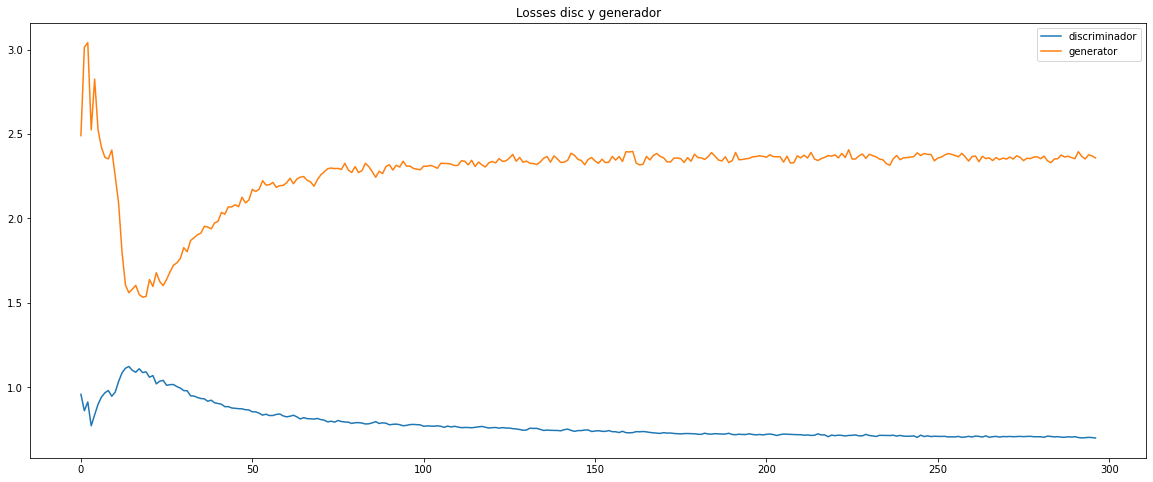

In [267]:
plt.figure(figsize = (20,8))
plt.plot(disc_loss_tracker_epoch, label = "discriminador")
plt.plot(gen_loss_tracker_epoch, label="generator")
plt.legend()
plt.title("Losses disc y generador")
plt.show()

In [ ]:
random_latent_vectors = tf.random.normal(shape=(32, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
fake_images = generator([random_latent_vectors])
n_row = 4
n_col = 8
_, axs = plt.subplots(n_row, n_col, figsize=(20,10))
axs = axs.flatten()
for img, ax in zip(fake_images, axs):
    ax.imshow((img+1)/2)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()


# Train solo imágenes con aumento adaptativo 

In [7]:
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 128
depth = 4
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 64
learning_rate = 2e-4
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99

### KID 

Kernel Inception Distance (KID) was proposed as a replacement for the popular Frechet Inception Distance (FID) metric for measuring image generation quality. Both metrics measure the difference in the generated and training distributions in the representation space of an InceptionV3 network pretrained on ImageNet.

According to the paper, KID was proposed because FID has no unbiased estimator, its expected value is higher when it is measured on fewer images. KID is more suitable for small datasets because its expected value does not depend on the number of samples it is measured on. In my experience it is also computationally lighter, numerically more stable, and simpler to implement because it can be estimated in a per-batch manner.

In this example, the images are evaluated at the minimal possible resolution of the Inception network (75x75 instead of 299x299), and the metric is only measured on the validation set for computational efficiency.

In [18]:
class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(BASE_SIZE, BASE_SIZE, 3)),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

### Adaptive discriminator augmentation

The authors of StyleGAN2-ADA propose to change the augmentation probability adaptively during training. Though it is explained differently in the paper, they use integral control on the augmentation probability to keep the discriminator's accuracy on real images close to a target value. Note, that their controlled variable is actually the average sign of the discriminator logits (r_t in the paper), which corresponds to 2 * accuracy - 1.

This method requires two hyperparameters:

+ target_accuracy: the target value for the discriminator's accuracy on real images. I recommend selecting its value from the 80-90% range.
+ integration_steps: the number of update steps required for an accuracy error of 100% to transform into an augmentation probability increase of 100%. To give an intuition, this defines how slowly the augmentation probability is changed. I recommend setting this to a relatively high value (1000 in this case) so that the augmentation strength is only adjusted slowly.

The main motivation for this procedure is that the optimal value of the target accuracy is similar across different dataset sizes (see figure 4 and 5 in the paper), so it does not have to be retuned, because the process automatically applies stronger data augmentation when it is needed.

In [38]:
# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return tf.math.round(values)
    # return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show (see figure 4), that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(BASE_SIZE, BASE_SIZE, 3)),
                # blitting/x-flip:
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )

### Modelos

In [45]:
# DCGAN generator
def get_generator():
    noise_input = keras.Input(shape=(NOISE_SIZE,))
    x = layers.Dense(4 * 4 * width, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(4, 4, width))(x)
    for _ in range(depth - 1):
        x = layers.Conv2DTranspose(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)
    image_output = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", activation="tanh",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(BASE_SIZE, BASE_SIZE, 3))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width, kernel_size=4, strides=2, padding="same", use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)
    output_score =layers.Activation('sigmoid')(output_score)

    return keras.Model(image_input, output_score, name="discriminator")

In [46]:
epochs = 300
batch_size = 64
learning_rate = 2e-4
beta_1 = 0.5
beta_2 = 0.9
num_train_gen = 1 #por cada batch cuantas veces entrenamos el generador
num_train_disc = 1
cuantas_imgs_vis = 3 #imagenes que vamos viendo al entrenar al final de cada epoca
kl_divergence_loss_coeff = 1

split = "train"
prepare_caption_train = PREPARE_CAPTIONS(data_dir, split)
filenames_train, captions_train = prepare_caption.load_text_data(data_dir, split)
prepare_image_train = PREPARE_IMAGE(data_dir, split, captions_train, filenames_train, BASE_SIZE)

dataset_train = tf.data.Dataset.range(len(filenames_train)) 
dataset_train = dataset_train.shuffle(buffer_size=len(filenames_train)) # comment this line if you don't want to shuffle data
dataset_train = dataset_train.batch(batch_size=batch_size, drop_remainder=True)
dataset_train = dataset_train.repeat(epochs)

split = "test"
prepare_caption_test = PREPARE_CAPTIONS(data_dir, split)
filenames_test, captions_test = prepare_caption.load_text_data(data_dir, split)
prepare_image_test = PREPARE_IMAGE(data_dir, split, captions_test, filenames_test, BASE_SIZE)

dataset_test = tf.data.Dataset.range(len(filenames_test)) 
dataset_test = dataset_test.shuffle(buffer_size=len(filenames_test)) # comment this line if you don't want to shuffle data
dataset_test = dataset_test.batch(batch_size=batch_size, drop_remainder=True)
#dataset_test = dataset_test.repeat(epochs)

augmenter = AdaptiveAugmenter()
generator = get_generator()
ema_generator = keras.models.clone_model(generator)
discriminator = get_discriminator()
generator.summary()
discriminator.summary()
kid = KID()
#discriminator = Discriminador()
#generator = Generator()
#model_clip = TFCLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
loss_fn = tf.keras.losses.BinaryCrossentropy()#from_logits=True)

def train_step(real_images):
    # Sample random points in the latent space
    loss_disc = 0
    real_images = tf.convert_to_tensor(real_images)
    real_images = augmenter(real_images)

    for _ in range(num_train_disc):
        random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_SIZE))
        # Decode them to fake images
        generated_images = generator(random_latent_vectors)
        # gradient is calculated through the image augmentation
        generated_images = augmenter(generated_images)
        labels = tf.zeros((batch_size, 1))
        # Add random noise to the labels - important trick!
        labels += 0.2 * tf.random.uniform(labels.shape)
    
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(generated_images)
            #predictions_real = discriminator(real_images)
            d_loss = loss_fn(labels, predictions)
            #gp = gradient_penalty(batch_size, real_images, generated_images)
            #d_loss = discriminator_loss(predictions_real, predictions_fake)+10*gp
            loss_disc +=d_loss
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        labels = tf.ones((batch_size, 1))
        # Add random noise to the labels - important trick!
        labels -= 0.2 * tf.random.uniform(labels.shape)
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(real_images)
            d_loss = loss_fn(labels, predictions)
            loss_disc +=d_loss
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    augmenter.update(predictions)
    # Sample random points in the latent space
    loss_gen = 0
    misleading_labels = tf.ones((2*batch_size, 1))

    for _ in range(num_train_gen):
        random_latent_vectors = tf.random.normal(shape=(2*batch_size, NOISE_SIZE))
        # Assemble labels that say "all real images"

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = generator(random_latent_vectors)
            generated_images = augmenter(generated_images)
            predictions = discriminator(generated_images)
            g_loss = loss_fn(misleading_labels, predictions)
            #g_loss = generator_loss(predictions)
            loss_gen += g_loss 
        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
        
        
        
    # track the exponential moving average of the generator's weights to decrease
    # variance in the generation quality
    for weight, ema_weight in zip(generator.weights, ema_generator.weights):
        ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
        
    return loss_disc, loss_gen



def generate(batch_size, training):
    latent_samples = tf.random.normal(shape=(batch_size, NOISE_SIZE))
    # use ema_generator during inference
    if training:
        generated_images = generator(latent_samples, training)
    else:
        generated_images = ema_generator(latent_samples, training)
    return generated_images

def test_step(real_images):
    # KID is not measured during the training phase for computational efficiency

    real_images = tf.convert_to_tensor(real_images)

    generated_images = generate(batch_size, training=False)

    kid.update_state(real_images, generated_images)

    # only KID is measured during the evaluation phase for computational efficiency
    return {kid.name: kid.result()}

Load filenames from: ../data/birds/train/filenames.pickle (8855)
Load filenames from: ../data/birds/train/filenames.pickle (8855)
filepath ../data/birds\captions.pickle
Load from:  ../data/birds\captions.pickle
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenames from: ../data/birds/test/filenames.pickle (2933)
Load filenames from: ../data/birds/test/filenames.pickle (2933)
filepath ../data/birds\captions.pickle
Load from:  ../data/birds\captions.pickle
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_17 (Dense)            (None, 2048)              262144    
                                                           

In [ ]:
epoca = 0
num_batch = 0
when_end_epoch =int(len(filenames_train)/batch_size+1)
print("EPOCA:", epoca)

disc_loss_tracker_batch = []
gen_loss_tracker_batch = []
#kl_loss_tracker_batch = []
disc_loss_tracker_epoch = []
gen_loss_tracker_epoch = []
#kl_loss_tracker_epoch = []
kid_accuracy_epoch = []
for batch in tqdm(dataset_train):
    if num_batch!=0 and num_batch%when_end_epoch==0:
        # test
        for batch_test in tqdm(dataset_test):
            imgs_list_test = []
            #caps_list_test = []
            for ind in batch_test:
                imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image_test.__getitem__(ind)
                imgs_list_test.append(imgs)
                #caps_list_test.append(caps)
            kid_accuracy_epoch.append(test_step(imgs_list_test)["kid"].numpy())
        print("KID en validation:",np.mean(kid_accuracy_epoch))
        # random_latent_vectors = tf.random.uniform(shape=(cuantas_imgs_vis, NOISE_SIZE), minval=-1, maxval=1)
        random_latent_vectors = tf.random.normal(shape=(cuantas_imgs_vis, NOISE_SIZE), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
        fake_images = generator([random_latent_vectors])
        for title, img in zip(caps_list[:cuantas_imgs_vis], fake_images):
            img = (img+1)/2
            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            #plt.title(title)
            plt.show()
            plt.close()
            
        disc_loss_tracker_epoch.append(np.mean([disc_loss_tracker_batch]))
        gen_loss_tracker_epoch.append(np.mean([gen_loss_tracker_batch]))
        #kl_loss_tracker_epoch.append(np.mean([kl_loss_tracker_batch]))

        epoca+=1
        print("EPOCA:", epoca)
        disc_loss_tracker_batch = []
        gen_loss_tracker_batch = []
        #kl_loss_tracker_batch = []

    # Cargo el batch y lo preparo ordenandolo en funcion de mas o menos palabras en el cap
    # imgs_list, caps_list, cap_len_list, cls_id_list, key_list, wrong_caps_list, wrong_cap_len_list, wrong_cls_id_list = [], [], [], [], [], [], [], [] 
    imgs_list, caps_list, cls_id_list, key_list, wrong_caps_list, wrong_cls_id_list = [], [], [], [], [], []

    for ind in batch:
        imgs, caps, cls_id, key, wrong_caps, wrong_cls_id = prepare_image_train.__getitem__(ind)
        imgs_list.append(imgs)
        caps_list.append(caps)

    loss_disc, loss_gen = train_step(imgs_list)
    disc_loss_tracker_batch.append(loss_disc/num_train_disc)
    gen_loss_tracker_batch.append(loss_gen/num_train_gen)
    if num_batch%(when_end_epoch//10)==0:
        print("Loss DISC:", np.mean([disc_loss_tracker_batch]), "Loss GEN:", np.mean([gen_loss_tracker_batch]))
        
    num_batch += 1